In [ ]:
import os
import shutil
import random
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)

2026-02-19 14:34:56.526678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771511696.835194      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771511696.928379      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771511697.698962      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771511697.699009      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771511697.699012      55 computation_placer.cc:177] computation placer alr

2.19.0


In [ ]:
import shutil, random, os
from pathlib import Path

original_root = Path("/kaggle/input/datasets/akashbhavanisankar/eurosat-rgb/EuroSAT_RGB")
split_root    = Path("/kaggle/working/EuroSAT_RGB_split")

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

random.seed(42)

for split in ["train", "val", "test"]:
    (split_root / split).mkdir(parents=True, exist_ok=True)

for class_name in os.listdir(original_root):
    class_dir = original_root / class_name
    if not class_dir.is_dir():
        continue

    images = [f for f in os.listdir(class_dir)
              if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff"))]
    images.sort()
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val   = int(val_ratio * n_total)
    n_test  = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files   = images[n_train:n_train+n_val]
    test_files  = images[n_train+n_val:]

    for split_name, file_list in zip(["train", "val", "test"],
                                     [train_files, val_files, test_files]):
        target_class_dir = split_root / split_name / class_name
        target_class_dir.mkdir(parents=True, exist_ok=True)
        for fname in file_list:
            src = class_dir / fname
            dst = target_class_dir / fname
            if not dst.exists():
                shutil.copy2(src, dst)

print("Done splitting into train/val/test at:", split_root)
print("Train classes:", os.listdir(split_root / "train"))

Done splitting into train/val/test at: /kaggle/working/EuroSAT_RGB_split
Train classes: ['AnnualCrop', 'HerbaceousVegetation', 'EuroSAT_RGB', 'Pasture', 'Industrial', 'Highway', 'SeaLake', 'Residential', 'PermanentCrop', 'Forest', 'River']


In [ ]:
data_root = split_root

train_dir = str(data_root / "train")
val_dir   = str(data_root / "val")
test_dir  = str(data_root / "test")

IMG_SIZE   = 64
BATCH_SIZE = 64

In [ ]:
import os
all_classes = sorted(os.listdir(train_dir))
print("All detected folders:", all_classes)
valid_classes = [c for c in all_classes if c != "EuroSAT_RGB"]
print("Using classes:", valid_classes, "len:", len(valid_classes))

All detected folders: ['AnnualCrop', 'EuroSAT_RGB', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Using classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] len: 10


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=15,width_shift_range=0.1,
    height_shift_range=0.1,horizontal_flip=True,
    vertical_flip=False,fill_mode="nearest")

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),color_mode='rgb',class_mode='sparse',
    batch_size=BATCH_SIZE,shuffle=True,classes=valid_classes)

val_gen = val_test_datagen.flow_from_directory(val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),color_mode='rgb',
    class_mode='sparse',batch_size=BATCH_SIZE,shuffle=False,
    classes=valid_classes)

test_gen = val_test_datagen.flow_from_directory(test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),color_mode='rgb',class_mode='sparse',
    batch_size=BATCH_SIZE,shuffle=False,classes=valid_classes)

class_names = list(train_gen.class_indices.keys())
NUM_CLASSES = len(class_names)
print("Classes:", class_names, "Num classes:", NUM_CLASSES)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] Num classes: 10


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True,mode="min",verbose=1)
MAX_EPOCHS = 20

*****Baseline CNN (with BN, Dropout, L2)*****

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def build_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    l2_reg = regularizers.l2(1e-4)

    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), padding="same", use_bias=False,kernel_regularizer=l2_reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), padding="same", use_bias=False,kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, kernel_regularizer=l2_reg)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="baseline_cnn_leaky")
    return model
baseline_model = build_baseline_cnn()
baseline_model.summary()

2026-02-19 14:56:56.426405: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "baseline_cnn_leaky"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,118,250 (8.08 MB)

 Trainable params: 2,118,058 (8.08 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
baseline_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history_baseline = baseline_model.fit(train_gen,validation_data=val_gen,epochs=MAX_EPOCHS,callbacks=[early_stop])

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 132s 437ms/step - accuracy: 0.3572 - loss: 3.5270 - val_accuracy: 0.2356 - val_loss: 2.6263
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 126s 424ms/step - accuracy: 0.5663 - loss: 1.3554 - val_accuracy: 0.6780 - val_loss: 0.9524
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 123s 416ms/step - accuracy: 0.6401 - loss: 1.0946 - val_accuracy: 0.3894 - val_loss: 3.3334
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 132s 445ms/step - accuracy: 0.6808 - loss: 0.9637 - val_accuracy: 0.4052 - val_loss: 4.8081
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 130s 439ms/step - accuracy: 0.6963 - loss: 0.9373 - val_accuracy: 0.7422 - val_loss: 0.8279
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 126s 424ms/step - accuracy: 0.7254 - loss: 0.8550 - val_accuracy: 0.5886 - val_loss: 1.7125
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 124s 420ms/step - accuracy: 0.7336 - loss: 0.8282 - val_accuracy: 0.6044 - val_loss: 1.8283
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 125s 422ms/step - accuracy: 0.7548 -

*****Custom CNN with SatBlock (BN, Dropout, L2)*****

In [ ]:
from tensorflow.keras.layers import LeakyReLU
def sat_block(x, filters, dropout_rate=0.3, name_prefix="sat"):
    l2_reg = regularizers.l2(1e-4)

    x = layers.Conv2D(filters, (3,3), padding="same", use_bias=False,kernel_regularizer=l2_reg,name=f"{name_prefix}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn1")(x)
    x = LeakyReLU(alpha=0.1, name=f"{name_prefix}_lrelu1")(x)

    x = layers.Conv2D(filters, (3,3), padding="same", use_bias=False,kernel_regularizer=l2_reg,name=f"{name_prefix}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name_prefix}_bn2")(x)
    x = LeakyReLU(alpha=0.1, name=f"{name_prefix}_lrelu2")(x)

    x = layers.MaxPooling2D((2,2), name=f"{name_prefix}_pool")(x)
    x = layers.Dropout(dropout_rate, name=f"{name_prefix}_drop")(x)
    return x

def build_custom_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    l2_reg = regularizers.l2(1e-4)
    inputs = keras.Input(shape=input_shape, name="input")

    x = layers.Conv2D(32, (3,3), padding="same", use_bias=False,kernel_regularizer=l2_reg, name="stem_conv")(inputs)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = LeakyReLU(alpha=0.1, name="stem_lrelu")(x)

    x = sat_block(x, 64,  dropout_rate=0.3, name_prefix="sat1")
    x = sat_block(x, 128, dropout_rate=0.3, name_prefix="sat2")
    x = sat_block(x, 256, dropout_rate=0.4, name_prefix="sat3")

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(256, kernel_regularizer=l2_reg, name="dense1")(x)
    x = LeakyReLU(alpha=0.1, name="dense1_lrelu")(x)
    x = layers.Dropout(0.5, name="dense_drop")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = keras.Model(inputs, outputs, name="custom_satellite_cnn_leaky")
    return model

custom_model = build_custom_cnn()
custom_model.summary()

Model: "custom_satellite_cnn_leaky"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_conv (Conv2D)              │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_bn (BatchNormalization)    │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_lrelu (LeakyReLU)          │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_conv1 (Conv2D)             │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_bn1 (BatchNormalization)   │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_lrelu1 (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_conv2 (Conv2D)             │ (None, 64, 64, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_bn2 (BatchNormalization)   │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_lrelu2 (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_pool (MaxPooling2D)        │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat1_drop (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_conv1 (Conv2D)             │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_bn1 (BatchNormalization)   │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_lrelu1 (LeakyReLU)         │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_conv2 (Conv2D)             │ (None, 32, 32, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_bn2 (BatchNormalization)   │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_lrelu2 (LeakyReLU)         │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_pool (MaxPooling2D)        │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat2_drop (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat3_conv1 (Conv2D)             │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat3_bn1 (BatchNormalization)   │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat3_lrelu1 (LeakyReLU)         │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat3_conv2 (Conv2D)             │ (None, 16, 16, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sat3_bn2 (BatchNormalization)   │ (None, 16, 16, 256)    │         1,02

 Total params: 1,234,154 (4.71 MB)

 Trainable params: 1,232,298 (4.70 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
custom_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history_custom = custom_model.fit( train_gen,validation_data=val_gen,epochs=MAX_EPOCHS,callbacks=[early_stop])

Epoch 1/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1273s 4s/step - accuracy: 0.5298 - loss: 1.4521 - val_accuracy: 0.2232 - val_loss: 3.7101
Epoch 2/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1267s 4s/step - accuracy: 0.7318 - loss: 0.8643 - val_accuracy: 0.6220 - val_loss: 1.4897
Epoch 3/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1241s 4s/step - accuracy: 0.7876 - loss: 0.7280 - val_accuracy: 0.6400 - val_loss: 1.6611
Epoch 4/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1239s 4s/step - accuracy: 0.8047 - loss: 0.6674 - val_accuracy: 0.5232 - val_loss: 2.0798
Epoch 5/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1244s 4s/step - accuracy: 0.8323 - loss: 0.6024 - val_accuracy: 0.6822 - val_loss: 1.3663
Epoch 6/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1246s 4s/step - accuracy: 0.8419 - loss: 0.5648 - val_accuracy: 0.7314 - val_loss: 1.0699
Epoch 7/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1234s 4s/step - accuracy: 0.8650 - loss: 0.5058 - val_accuracy: 0.7867 - val_loss: 0.8386
Epoch 8/20
296/296 ━━━━━━━━━━━━━━━━━━━━ 1305s 4s/step - accuracy: 0.8773 - loss: 0.4733 - 

*****Plot training curves*****

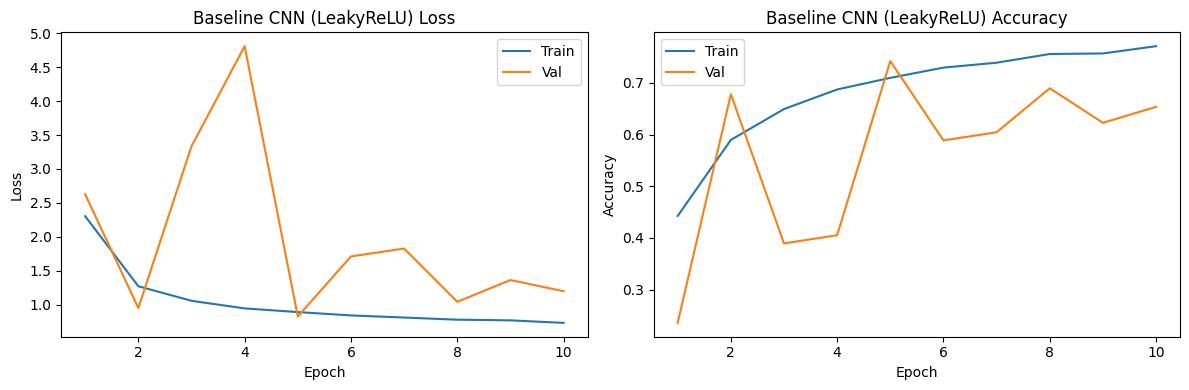

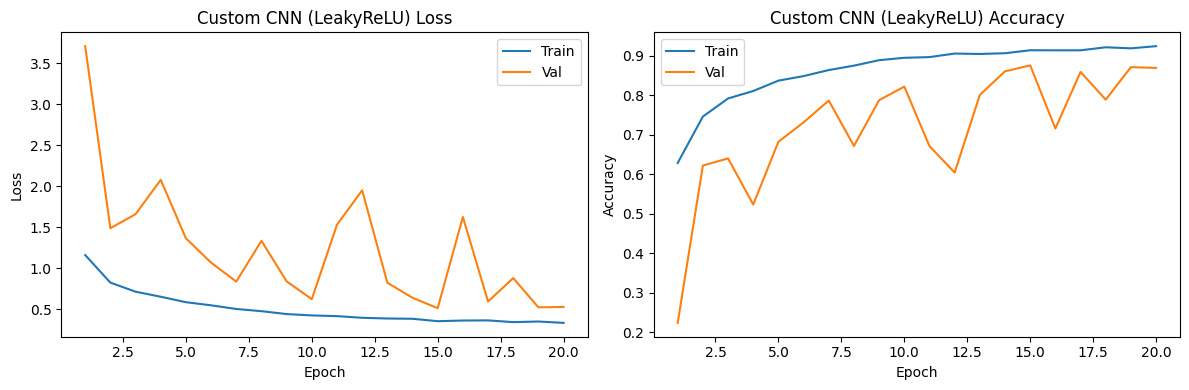

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history, title_prefix="Model"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, loss, label="Train")
    plt.plot(epochs_range, val_loss, label="Val")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, acc, label="Train")
    plt.plot(epochs_range, val_acc, label="Val")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_baseline, "Baseline CNN (LeakyReLU)")
plot_history(history_custom, "Custom CNN (LeakyReLU)")

*****Test evaluation and confusion matrix*****

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_loss, test_acc = custom_model.evaluate(test_gen)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

64/64 ━━━━━━━━━━━━━━━━━━━━ 58s 906ms/step - accuracy: 0.8556 - loss: 0.5795
Test loss: 0.5503035187721252
Test accuracy: 0.8659259080886841


In [ ]:
y_true = []
y_pred = []
images_list = []

for i in range(len(test_gen)):
    batch_images, batch_labels = test_gen[i]
    preds = custom_model.predict(batch_images, verbose=0)
    preds_labels = np.argmax(preds, axis=1)
    y_true.extend(batch_labels)
    y_pred.extend(preds_labels)
    images_list.extend(batch_images)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
images_list = np.array(images_list)

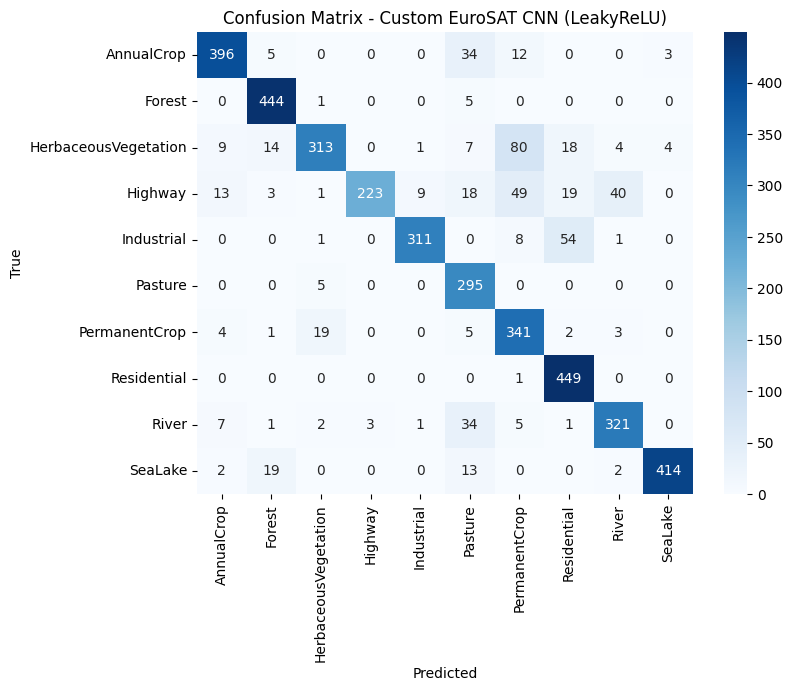

                      precision    recall  f1-score   support

          AnnualCrop       0.92      0.88      0.90       450
              Forest       0.91      0.99      0.95       450
HerbaceousVegetation       0.92      0.70      0.79       450
             Highway       0.99      0.59      0.74       375
          Industrial       0.97      0.83      0.89       375
             Pasture       0.72      0.98      0.83       300
       PermanentCrop       0.69      0.91      0.78       375
         Residential       0.83      1.00      0.90       450
               River       0.87      0.86      0.86       375
             SeaLake       0.98      0.92      0.95       450

            accuracy                           0.87      4050
           macro avg       0.88      0.87      0.86      4050
        weighted avg       0.88      0.87      0.86      4050



In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom EuroSAT CNN (LeakyReLU)")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

*****Misclassification visualization*****

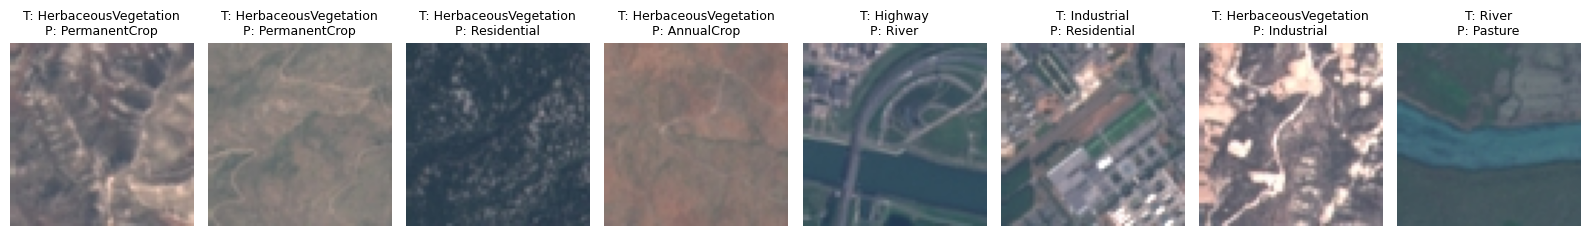

In [ ]:
def show_errors(images, preds, labels, class_names, n=8):
    errors_idx = np.where(preds != labels)[0]
    if len(errors_idx) == 0:
        print("No misclassifications found.")
        return

    sample_idx = np.random.choice(errors_idx, size=min(n, len(errors_idx)), replace=False)

    plt.figure(figsize=(16,4))
    for i, idx in enumerate(sample_idx):
        img = images[idx]
        plt.subplot(1, len(sample_idx), i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {class_names[int(labels[idx])]}\nP: {class_names[int(preds[idx])]}", fontsize=9)
    plt.tight_layout()
    plt.show()

show_errors(images_list, y_pred, y_true, class_names, n=8)

*****Grad‑CAM (on custom LeakyReLU CNN)*****

In [ ]:
import tensorflow as tf
import cv2

last_conv_layer_name = "sat3_conv2"  # from the custom model
grad_model = keras.models.Model([custom_model.inputs], [custom_model.get_layer(last_conv_layer_name).output, custom_model.output])

In [ ]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam_on_image(img, heatmap, alpha=0.4):
    img_disp = np.uint8(255 * img)
    heatmap_resized = cv2.resize(heatmap, (img_disp.shape[1], img_disp.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_disp, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(img_disp)
    plt.axis("off")
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM")
    plt.tight_layout()
    plt.show()

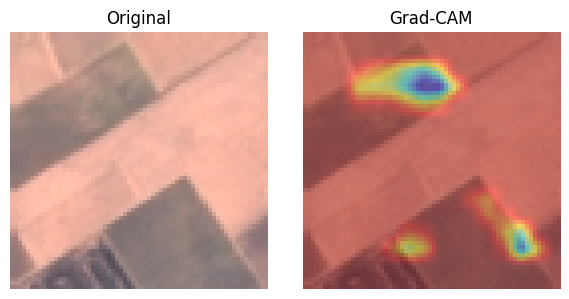

In [ ]:
errors_idx = np.where(y_pred != y_true)[0]
if len(errors_idx) > 0:
    idx = int(errors_idx[0])
    img = images_list[idx]
    img_batch = np.expand_dims(img, axis=0)
    heatmap = make_gradcam_heatmap(img_batch, grad_model, pred_index=y_pred[idx])
    display_gradcam_on_image(img,heatmap)
else:
    print("No misclassified samples to visualize.")